In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd /content/drive/MyDrive/ML-LaDECO/LaDECO

/content/drive/MyDrive/ML-LaDECO/LaDECO


In [4]:
import tensorflow as tf
print('TensorFlow Version',tf.__version__)

TensorFlow Version 2.8.0


In [5]:
import numpy as np

print('Project MLaDECO')
print('Author: Viswambhar Yasa')
print('Software version: 0.1')
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf
from tensorflow.keras import models
from thermograms.Utilities import Utilities
from ml_training.dataset_generation.fourier_transformation import fourier_transformation
from ml_training.dataset_generation.principal_componant_analysis import principal_componant_analysis
from utilites.segmentation_colormap_anno import segmentation_colormap_anno
from utilites.tolerance_maks_gen import tolerance_predicted_mask
import matplotlib.pyplot as plt

Project MLaDECO
Author: Viswambhar Yasa
Software version: 0.1


In [6]:
root_path = r'utilites/datasets'
data_file_name = r'metal_data.hdf5'
thermal_class = Utilities()
thermal_data,experiment_list=thermal_class.open_file(root_path, data_file_name,True)
experiment_name=r'2021-12-15-Materialstudie_Metallproben-ML1-laserbehandelte_Probe-1000W-10s'
experimental_data=thermal_data[experiment_name] 

Experiments in the file 

1  :  2021-12-15-Materialstudie_Metallproben-ML1-laserbehandelte_Probe-1000W-10s
2  :  2021-12-15-Materialstudie_Metallproben-ML2-laserbehandelte_Probe-1000W-10s
3  :  2021-12-15-Materialstudie_Metallproben-ML3-laserbehandelte_Probe-1000W-10s


A total of 3 experiments are loaded in file  



In [7]:
input_data, reflection_st_index, reflection_end_index = fourier_transformation(experimental_data,
                                                                               scaling_type='normalization', index=1)

reflection_start_index:  291   reflection_end_index:  791
The size of filtered data: (256, 256, 500)


In [8]:
from ml_training.dataset_generation.data_preprocessing import data_preprocessing1

In [9]:
#from data_train_test import data_preprocessing
#from data_train_test import data_preprocessing
dataset_genertor=data_preprocessing1()

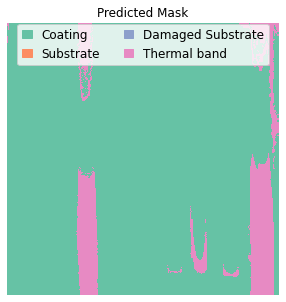

In [10]:
from utilites.segmentation_colormap_anno import segmentation_colormap_anno
combined_mask=np.load('ml_training/dataset_generation/annots/2021-12-15-Materialstudie_Metallproben-ML1-laserbehandelte_Probe-1000W-10s.npy')
segmentation_colormap_anno(combined_mask, heatmap='RdYlBu_r', file_name='seg_mask', disp=True)


In [11]:
annotation_path=r'ml_training/dataset_generation/annots//'
train_ds,valid_ds,test_ds=dataset_genertor.load_image_segmentation_dataset(thermal_data,experiment_list,annotation_path,save=True,num_classes=2)
#training_dataset,validation_dataset,testing_dataset=dataset_genertor.load_image_segmentation_dataset(thermal_data,experiment_list,annotation_path)

2021-12-15-Materialstudie_Metallproben-ML1-laserbehandelte_Probe-1000W-10s
296 791
(256, 256, 495)
filtered dataset shape : (256, 256, 495) Shape after concatenation : (256, 256, 495)
2021-12-15-Materialstudie_Metallproben-ML2-laserbehandelte_Probe-1000W-10s
438 938
(256, 256, 500)
filtered dataset shape : (256, 256, 500) Shape after concatenation : (256, 256, 995)
2021-12-15-Materialstudie_Metallproben-ML3-laserbehandelte_Probe-1000W-10s
300 798
(256, 256, 498)
filtered dataset shape : (256, 256, 498) Shape after concatenation : (256, 256, 1493)


In [12]:
train_ds[0].shape, train_ds[1].shape

((256, 256, 1045), (256, 256, 4, 1045))

In [35]:
from tensorflow.keras import Input,Model
from tensorflow.keras.layers import RandomFlip,RandomTranslation,RandomRotation
import tensorflow as tf
def Augment(tar_shape=(256,256), seed=37,aug_types=1):
    img = Input(shape=(None,None))
    msk = Input(shape=(None,None))
    if aug_types==1:
        i = tf.keras.layers.RandomFlip(seed=seed)(img)
        m = tf.keras.layers.RandomFlip(seed=seed)(msk)
        return Model(inputs=(img,msk), outputs=(i,m))
    elif aug_types==2:
        i = RandomTranslation((-0.75, 0.75),(-0.75, 0.75),seed=seed)(i)
        m = RandomTranslation((-0.75, 0.75),(-0.75, 0.75),seed=seed)(m)
        return Model(inputs=(img,msk), outputs=(i,m))
    elif  aug_types==3:
        i = RandomRotation((-0.35, 0.35),seed=seed)(i)
        m = RandomRotation((-0.35, 0.35),seed=seed)(m)
        return Model(inputs=(img,msk), outputs=(i,m))
    elif  aug_types==4:
        i = RandomFlip(seed=seed)(img)
        m = RandomFlip(seed=seed)(msk)
        i = RandomTranslation((-0.75, 0.75),(-0.75, 0.75),seed=seed)(i)
        m = RandomTranslation((-0.75, 0.75),(-0.75, 0.75),seed=seed)(m)
        return Model(inputs=(img,msk), outputs=(i,m))
    elif  aug_types==5:
        i = RandomFlip(seed=seed)(img)
        m = RandomFlip(seed=seed)(msk)
        i = RandomTranslation((-0.75, 0.75),(-0.75, 0.75),seed=seed)(i)
        m = RandomTranslation((-0.75, 0.75),(-0.75, 0.75),seed=seed)(m)
        i = RandomRotation((-0.35, 0.35),seed=seed)(i)
        m = RandomRotation((-0.35, 0.35),seed=seed)(m)
        return Model(inputs=(img,msk), outputs=(i,m))

In [38]:
train_dataset=dataset_genertor.create_dataset(train_ds[0], train_ds[1])
valid_dataset=dataset_genertor.create_dataset(np.array(valid_ds[0]), valid_ds[1])
test_dataset=dataset_genertor.create_dataset(test_ds[0], test_ds[1])

In [30]:
repeated_ds=train_dataset.repeat(3)
len(repeated_ds),len(train_dataset)

(3135, 1045)

In [39]:
batch_size=64

In [40]:
training_dataset = train_dataset.batch(batch_size)
#training_dataset=aug_train_ds.batch(batch_size)
validation_dataset=valid_dataset.batch(batch_size)
#validation_dataset = new_validation_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)
len(train_dataset),len(validation_dataset),len(test_dataset)

(1045, 5, 3)

Text(0.5, 1.0, 'Expected Mask')

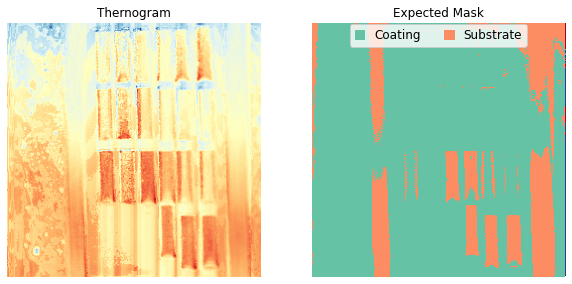

In [18]:
import seaborn as sns
from matplotlib.patches import Patch
data=next(iter(training_dataset))
i=23
image=data[0][i]
plots_image=np.squeeze(image)
true_anno=data[1][i]
anno1=np.zeros((256,256))
for i in range(4):
  temp=true_anno[:,:,i]
  anno1[temp==1]+=i
fig = plt.figure(figsize=(10, 7))
  
fig.add_subplot(1, 2, 1)
# showing image
plt.imshow(np.squeeze(image).astype(np.float32),cmap='RdYlBu_r')
plt.axis('off')
plt.title("Thernogram")
  

fig.add_subplot(1, 2, 2)
cmap = sns.mpl_palette("Set2", 2)
c=sns.heatmap(data=anno1, cmap=cmap, cbar=False)
plt.axis('off')

legend_handles = [Patch(color=cmap[0], label='Coating'),  # red
                  Patch(color=cmap[1], label='Substrate')]  # green
plt.legend(handles=legend_handles, ncol=2, bbox_to_anchor=[0.5, 1.02], loc='upper center', fontsize=12, handlelength=.8)
fig = c.get_figure()
# showing image
plt.imshow(anno1,cmap='RdYlBu_r')
#plt.axis('off')
plt.title("Expected Mask")

In [19]:
from therml.ml_models import U_Net

In [20]:
number_of_classes = 4
input_shape = (256, 256, 1)
filter_list = np.array([16,32,64, 128, 256,512])
u_net=U_Net()
segementation_model=u_net.create_model(number_of_classes,input_shape,filter_list,disp=False)

Building U-NET model 

Input shape : (None, 256, 256, 1)
pipline encoder output shape: (None, 8, 8, 256)
pipline bottle-neck output shape: (None, 8, 8, 512)
pipline decoder output shape: (None, 256, 256, 16)
output shape (None, 256, 256, 4) 

Model built sucessfully 



In [21]:
segementation_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [32]:
rlronp=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=10)
estop=tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=10,restore_best_weights=True)
callbacks=[rlronp, estop]

In [33]:
from datetime import datetime
import math

def step_decay(epoch):
	initial_lrate = 0.05
	drop = 0.5
	epochs_drop = 20
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate
lr_callback = tf.keras.callbacks.LearningRateScheduler(step_decay)

In [41]:
segementation_model.compile(loss=tf.keras.losses.categorical_crossentropy,
    #loss=dice_coef_loss,
              optimizer=tf.keras.optimizers.Adam(learning_rate=1E-3),
              metrics=[tf.keras.metrics.MeanIoU(num_classes=4),
              'accuracy'])

In [42]:
model_history = segementation_model.fit(training_dataset,batch_size=64,epochs=20,steps_per_epoch=1,verbose=1,shuffle=True,
                                        validation_data=validation_dataset,validation_batch_size=8,validation_steps=1,
                                        callbacks=callbacks)

Epoch 1/20
1/1 [==============================] - 5s 5s/step - loss: 1.0268 - mean_io_u_2: 0.3766 - accuracy: 0.6880 - val_loss: 0.7707 - val_mean_io_u_2: 0.3750 - val_accuracy: 0.7201 - lr: 0.0010
Epoch 2/20
1/1 [==============================] - 2s 2s/step - loss: 0.8650 - mean_io_u_2: 0.3751 - accuracy: 0.7514 - val_loss: 0.4898 - val_mean_io_u_2: 0.3750 - val_accuracy: 0.8707 - lr: 0.0010
Epoch 3/20
1/1 [==============================] - 2s 2s/step - loss: 0.6450 - mean_io_u_2: 0.3769 - accuracy: 0.8608 - val_loss: 0.4491 - val_mean_io_u_2: 0.3750 - val_accuracy: 0.8763 - lr: 0.0010
Epoch 4/20
1/1 [==============================] - 2s 2s/step - loss: 0.4698 - mean_io_u_2: 0.3751 - accuracy: 0.8713 - val_loss: 0.4766 - val_mean_io_u_2: 0.3750 - val_accuracy: 0.8789 - lr: 0.0010
Epoch 5/20
1/1 [==============================] - 2s 2s/step - loss: 0.4558 - mean_io_u_2: 0.3751 - accuracy: 0.8687 - val_loss: 0.4911 - val_mean_io_u_2: 0.3750 - val_accuracy: 0.8827 - lr: 0.0010
Epoch 6/20

In [ ]:
model_para=model_history.history
path=r'trained_models\UNet\model_history\\'

In [ ]:
filename="u_net_64_metal_Adam_5.pkl"
file_path=path+filename
import pickle

# define dictionary

# create a binary pickle file 
f = open("u_net_64_Adam_5.pkl","wb")

# write the python object (dict) to pickle file
pickle.dump(model_para,f)
# close file
f.close()

In [ ]:
segementation_model.evaluate(validation_dataset)

13/13 [==============================] - 5s 292ms/step - loss: 0.3647 - mean_io_u: 0.5083 - accuracy: 0.8527


[0.36466559767723083, 0.5083286762237549, 0.8527065515518188]

In [ ]:
segementation_model.evaluate(test_dataset)

6/6 [==============================] - 7s 971ms/step - loss: 0.3657 - mean_io_u: 0.4944 - accuracy: 0.8537


[0.36572179198265076, 0.4944290518760681, 0.8537335991859436]

In [43]:
model_save_path=r'trained_models\UNet\\'

In [44]:
model_name=r'u_net_64_adam_metal_best.h5'
model_path=model_save_path+model_name
segementation_model.save(model_path,overwrite=False)

In [28]:
saved_model_path=r'/content/drive/MyDrive/ML-LaDECO/LaDECO/trained_models/UNet/u_net_64_Adam_5_best_agu.h5'

In [29]:
segementation_model=tf.keras.models.load_model(saved_model_path)

In [ ]:
input_image=tf.expand_dims(image,axis=0)
testdata=next(iter(test_dataset))
predict=u_net.predict_on_batch(testdata[0])
predict.shape

(64, 256, 256, 4)

In [46]:
input_image=tf.expand_dims(image,axis=0)
testdata=next(iter(test_dataset))
predict=segementation_model.predict_on_batch(testdata[0])
predict.shape

(64, 256, 256, 4)

In [47]:
i=35
predicted=predict[i,:,:,:]
image=testdata[0][i]
predicted_anno=testdata[1][i]
anno=np.zeros((256,256))
for i in range(4):
  temp=predicted_anno[:,:,i].numpy()
  anno[temp==1]+=i

predicted[predicted>0.5]=1
predicted[predicted<0.5]=0
predicted=np.squeeze(predicted)
pre_anno=np.zeros((256,256))
for i in range(4):
  temp=predicted[:,:,i]
  pre_anno[temp==1]+=i

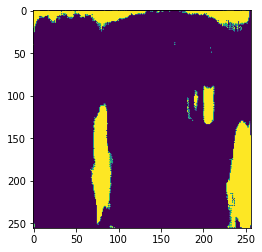

In [54]:
plt.imshow(pre_anno)

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns

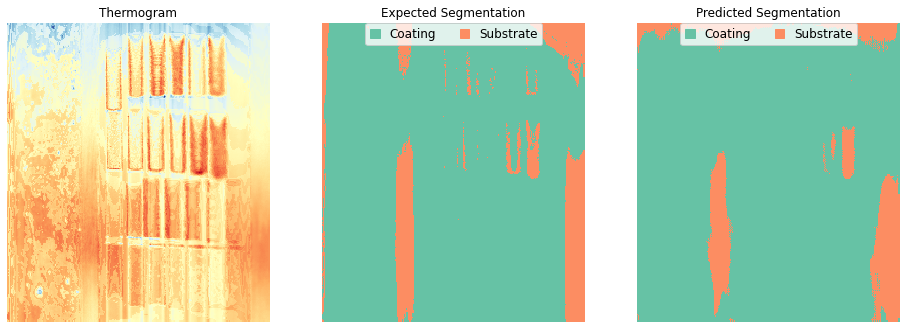

In [77]:

fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(16, 5.5))

sns.heatmap(data=np.squeeze(image),cmap='RdYlBu_r',cbar=False,ax=ax1)
ax1.axis('off')
ax1.set_title("Thermogram")
#ax1.collections[0].colorbar.set_label("Temperature (K)")
cmap = sns.mpl_palette("Set2", 2)
sns.heatmap(data=anno, cmap=cmap,cbar=False,ax=ax2)
ax2.axis('off')
ax2.set_title("Expected Segmentation")
legend_handles = [Patch(color=cmap[0], label='Coating'),  # red
                          Patch(color=cmap[1], label='Substrate')]
ax2.legend(handles=legend_handles, ncol=2, bbox_to_anchor=[0.5, 1.02], loc='upper center', fontsize=12, handlelength=.8)
#ax2.collections[0].colorbar.set_label(['0:Coating', '1:Substrate', '2:Damaged Substrate', '3:Thermal band'])
cmap = sns.mpl_palette("Set2", 2)
sns.heatmap(data=pre_anno, cmap=cmap,cbar=False,ax=ax3)
ax3.axis('off')
legend_handles = [Patch(color=cmap[0], label='Coating'),  # red
                          Patch(color=cmap[1], label='Substrate')]
ax3.legend(handles=legend_handles, ncol=2, bbox_to_anchor=[0.5, 1.02], loc='upper center', fontsize=12, handlelength=.8)
ax3.set_title("Predicted Segmentation")
plt.savefig(r"/content/sample_data/metal_prediction.png",dpi=100,bbox_inches='tight',transparent=True)
plt.show()